In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import ttest_1samp

%matplotlib inline
# load hourly data
hourly_data = pd.read_csv('hour.csv')

In [2]:
hourly_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# print some generic statsitics about the data
print('shape of data :{}'.format(hourly_data.shape))
print('Numbers of missing values in the data :\
{}'.format(hourly_data.isnull().sum().sum()))

shape of data :(17379, 17)
Numbers of missing values in the data :0


In [4]:
# get statistics on the numerical columns
hourly_data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


Preprocessing Temporal and Weather Features

In [5]:
# create a copy of the original data
preprocessed_data = hourly_data.copy()
#transform seasons mapping
seasons_mapping = {1: 'winter',2: 'spring',3: 'summer',4:'fall'}
def rename(x):
    return seasons_mapping[x]
preprocessed_data['season'] = preprocessed_data['season'].apply(rename)
#transform yr mapping
yr_mapping = {0: 2011,1: 2012}
def rename_column(data, column, mapping):
    data[column] = data[column].map(mapping)

rename_column(preprocessed_data, 'yr', yr_mapping)
weekday_mapping = {0:'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6:'Saturday'}
rename_column(preprocessed_data,'weekday',weekday_mapping)
#transform weathersit
weathersit_mapping = {1: 'clear', 2: 'cloudy', \
                      3:'light rain snow', 4: 'heavy rain snow'}
rename_column(preprocessed_data,'weathersit',weathersit_mapping)

#transform hum and windspeed
preprocessed_data['hum'] = preprocessed_data['hum'] * 100
preprocessed_data['windspeed'] = preprocessed_data['windspeed'] * 67
# visualize preprocessed columns
cols = ['season', 'yr', 'weekday', \
        'weathersit', 'hum', 'windspeed']
preprocessed_data[cols].sample(10)

,season,yr,weekday,weathersit,hum,windspeed
8640,winter,2011,Saturday,clear,54.0,15.0013
607,winter,2011,Friday,light rain snow,93.0,7.0015
14047,summer,2012,Monday,clear,40.0,12.9980
12528,spring,2012,Monday,clear,78.0,8.9981
16643,fall,2012,Saturday,clear,87.0,8.9981
6399,fall,2011,Thursday,cloudy,88.0,7.0015
6163,summer,2011,Monday,cloudy,68.0,11.0014
3544,spring,2011,Wednesday,clear,37.0,16.9979
10818,spring,2012,Saturday,cloudy,71.0,22.0028
262,winter,2011,Wednesday,clear,59.0,22.0028


In [6]:
#check that the total number of rides equal to the sum of number of rides for casual useres and for registered users
(preprocessed_data.casual + preprocessed_data.registered == preprocessed_data.cnt).all()

True

Text(0.5, 1.0, 'Rides distributions')

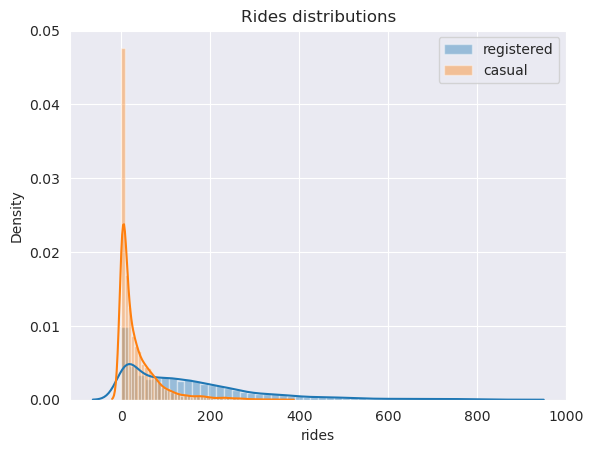

In [20]:
#plot the distribution of registered and casual rides
import warnings
warnings.filterwarnings('ignore')
sns.distplot(preprocessed_data['registered'], label='registered')
sns.distplot(preprocessed_data['casual'], label='casual')
plt.legend()
plt.xlabel('rides')
plt.title("Rides distributions")


Calculating number of rides per day within the Two years

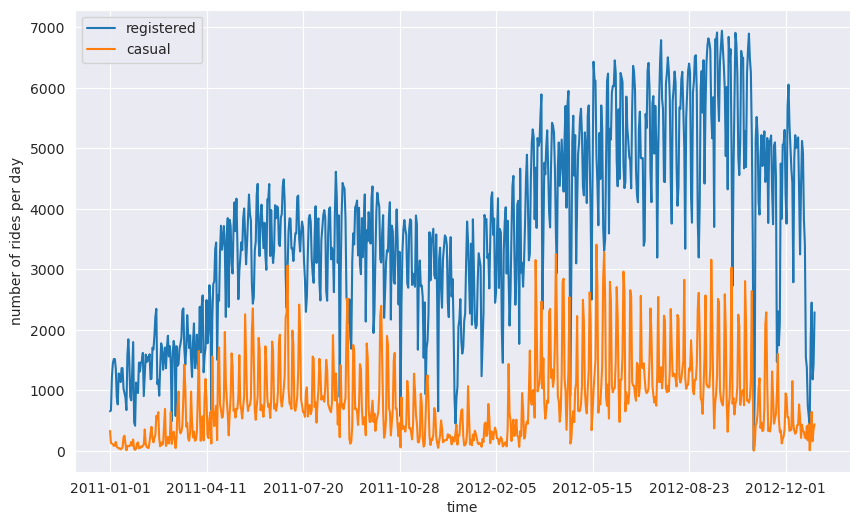

In [8]:
plot_data= preprocessed_data[['registered', 'casual', 'dteday']].groupby('dteday').sum()
ax = plot_data.plot(figsize = (10,6))
ax.set_xlabel("time");
ax.set_ylabel("number of rides per day");


In [9]:
plot_data = preprocessed_data[['registered', 'casual', 'dteday']]
plot_data = plot_data.groupby('dteday').sum()
plot_data
rolling_means = plot_data.rolling(7).mean()
rolling_std = plot_data.rolling(7).std()

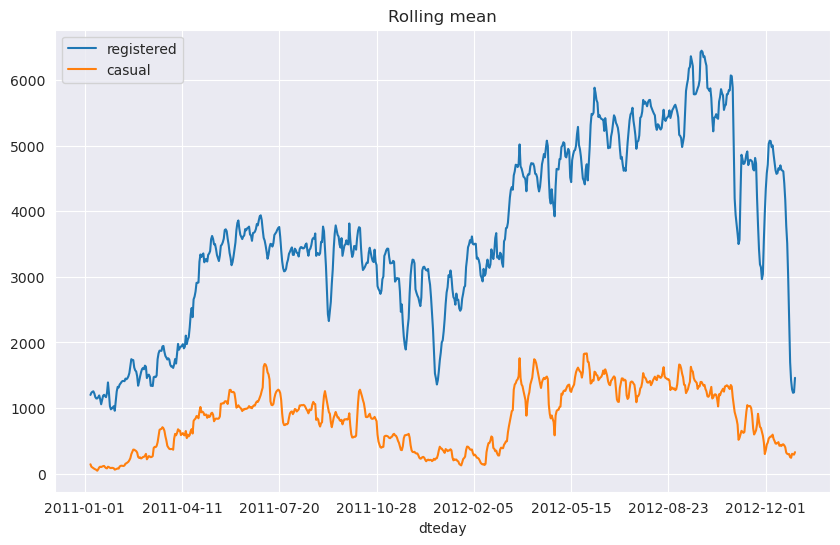

In [10]:
ax = rolling_means.plot(figsize=(10,6))
ax.set_title('Rolling mean');

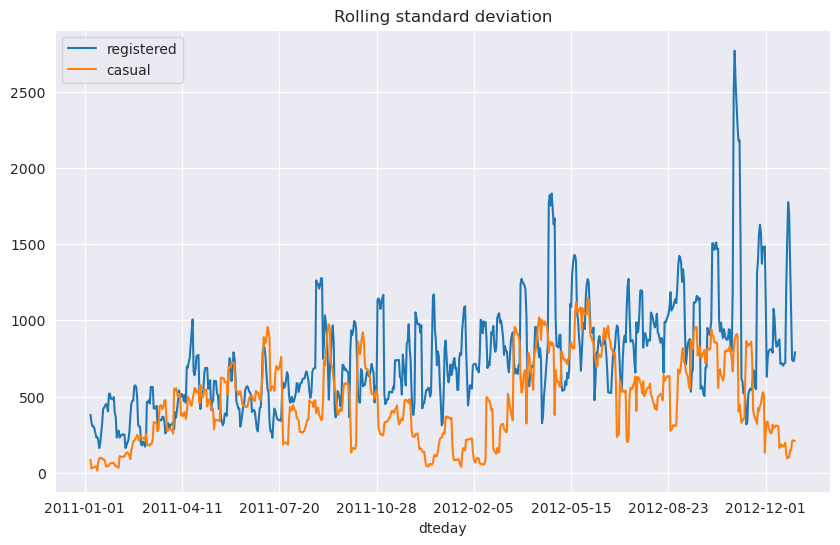

In [11]:
ax = rolling_std.plot(figsize = (10,6))
ax.set_title('Rolling standard deviation');

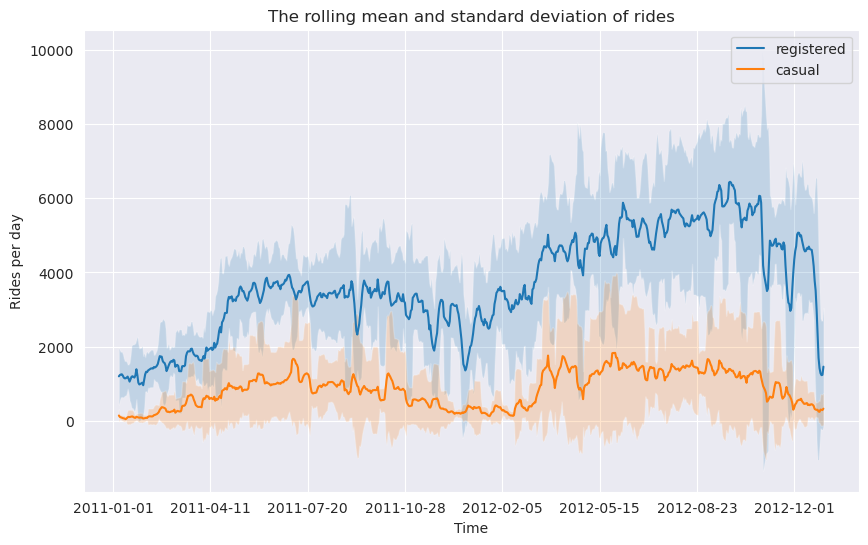

In [12]:
ax = rolling_means.plot(figsize=(10,6))
ax.fill_between(rolling_means.index,rolling_means['registered'] + 2*rolling_std['registered'], \
                rolling_means['registered'] - 2 * rolling_std['registered'], alpha = 0.2)
ax.fill_between(rolling_means.index, rolling_means['casual'] + 2 *rolling_std['casual'],\
                rolling_means['casual'] - 2 * rolling_std['casual'], alpha = .2)
ax.set_xlabel('Time')
ax.set_ylabel('Rides per day');
ax.set_title('The rolling mean and standard deviation of rides');

In [13]:
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars=['hr', 'weekday'], \
                value_name='count')
plot_data

,hr,weekday,variable,count
0,0,Saturday,registered,13
1,1,Saturday,registered,32
2,2,Saturday,registered,27
3,3,Saturday,registered,10
4,4,Saturday,registered,1
...,...,...,...,...
34753,19,Monday,casual,11
34754,20,Monday,casual,8
34755,21,Monday,casual,7
34756,22,Monday,casual,13


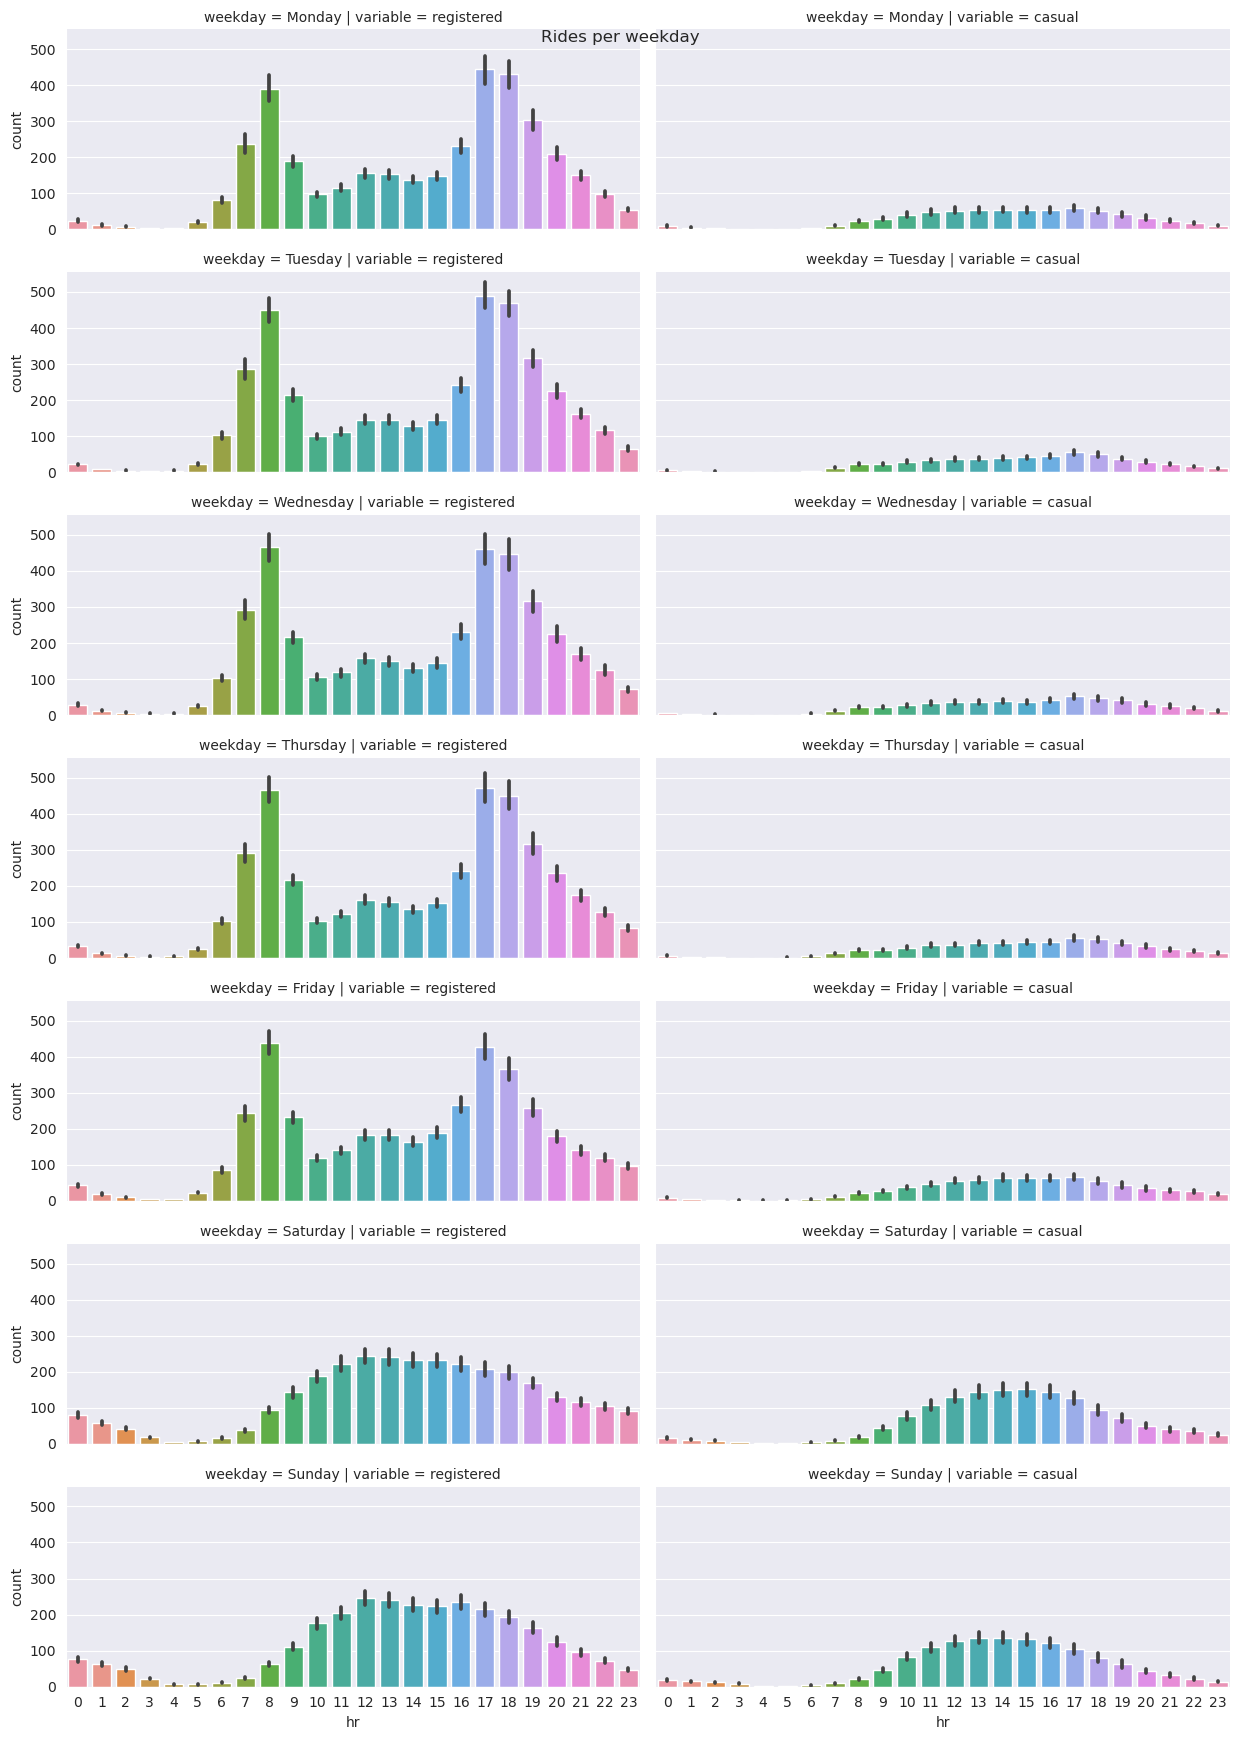

In [14]:
sns.catplot(x='hr', y='count', col='variable', row='weekday', kind='bar', \
            data=plot_data, height=2.5, aspect=2.5, col_order=['registered', 'casual'], \
            row_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', \
                       'Saturday', 'Sunday']);
plt.suptitle('Rides per weekday');

In [15]:
plot_data = preprocessed_data[['hr','season','registered','casual']]
# unpivot data from wide to long format
plot_data = plot_data.melt(id_vars=['hr','season'],var_name='type', value_name='count')
plot_data

,hr,season,type,count
0,0,winter,registered,13
1,1,winter,registered,32
2,2,winter,registered,27
3,3,winter,registered,10
4,4,winter,registered,1
...,...,...,...,...
34753,19,winter,casual,11
34754,20,winter,casual,8
34755,21,winter,casual,7
34756,22,winter,casual,13


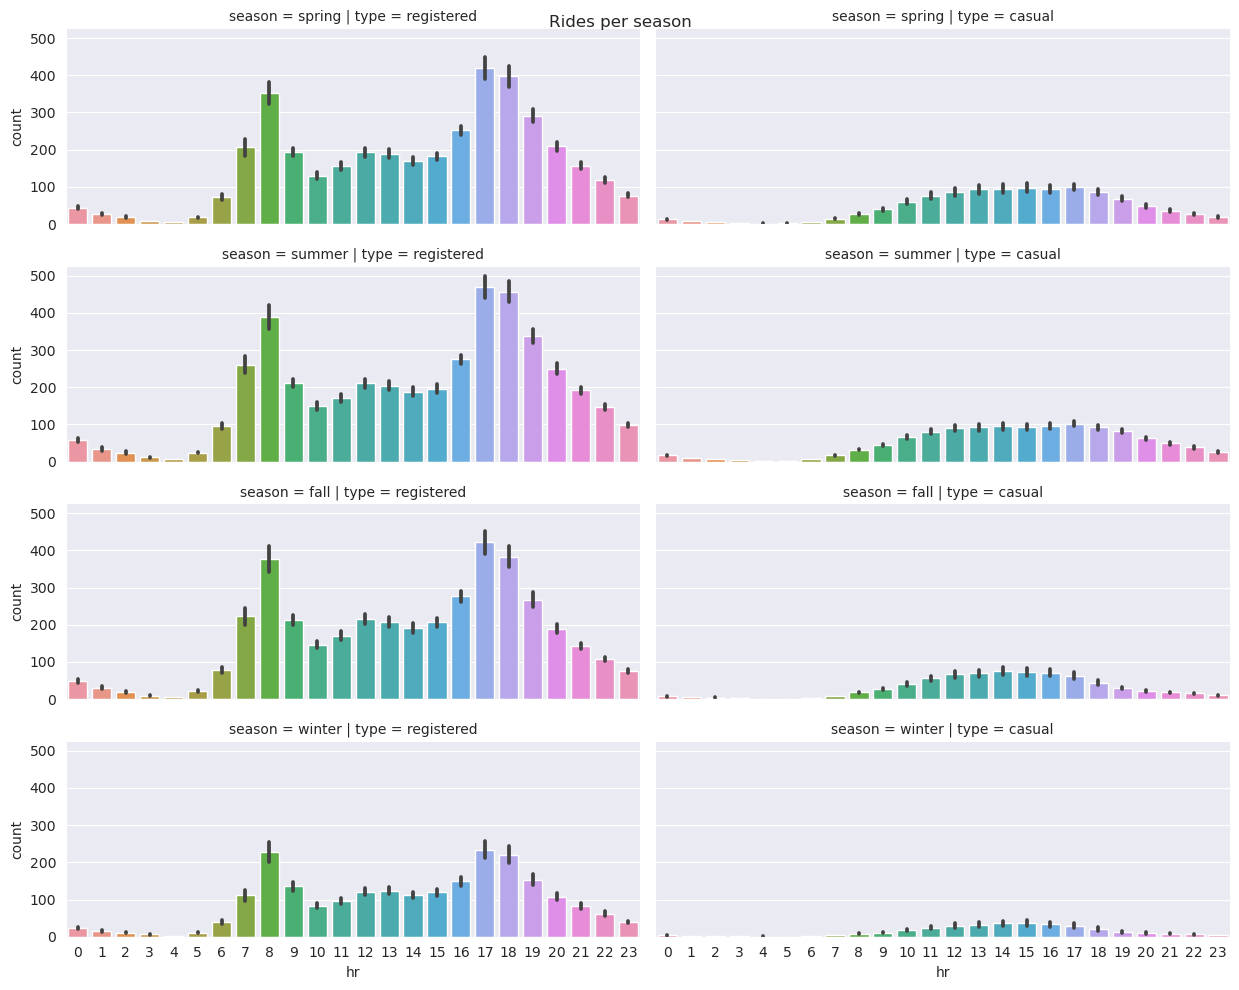

In [16]:
sns.catplot(x='hr', y='count',row='season',col='type', kind='bar', \
            data=plot_data, height=2.5, aspect=2.5, \
            row_order=['spring', 'summer', 'fall','winter'], \
            col_order=['registered', 'casual'])
plt.suptitle('Rides per season');

Text(0.5, 0.98, 'Rides per season')

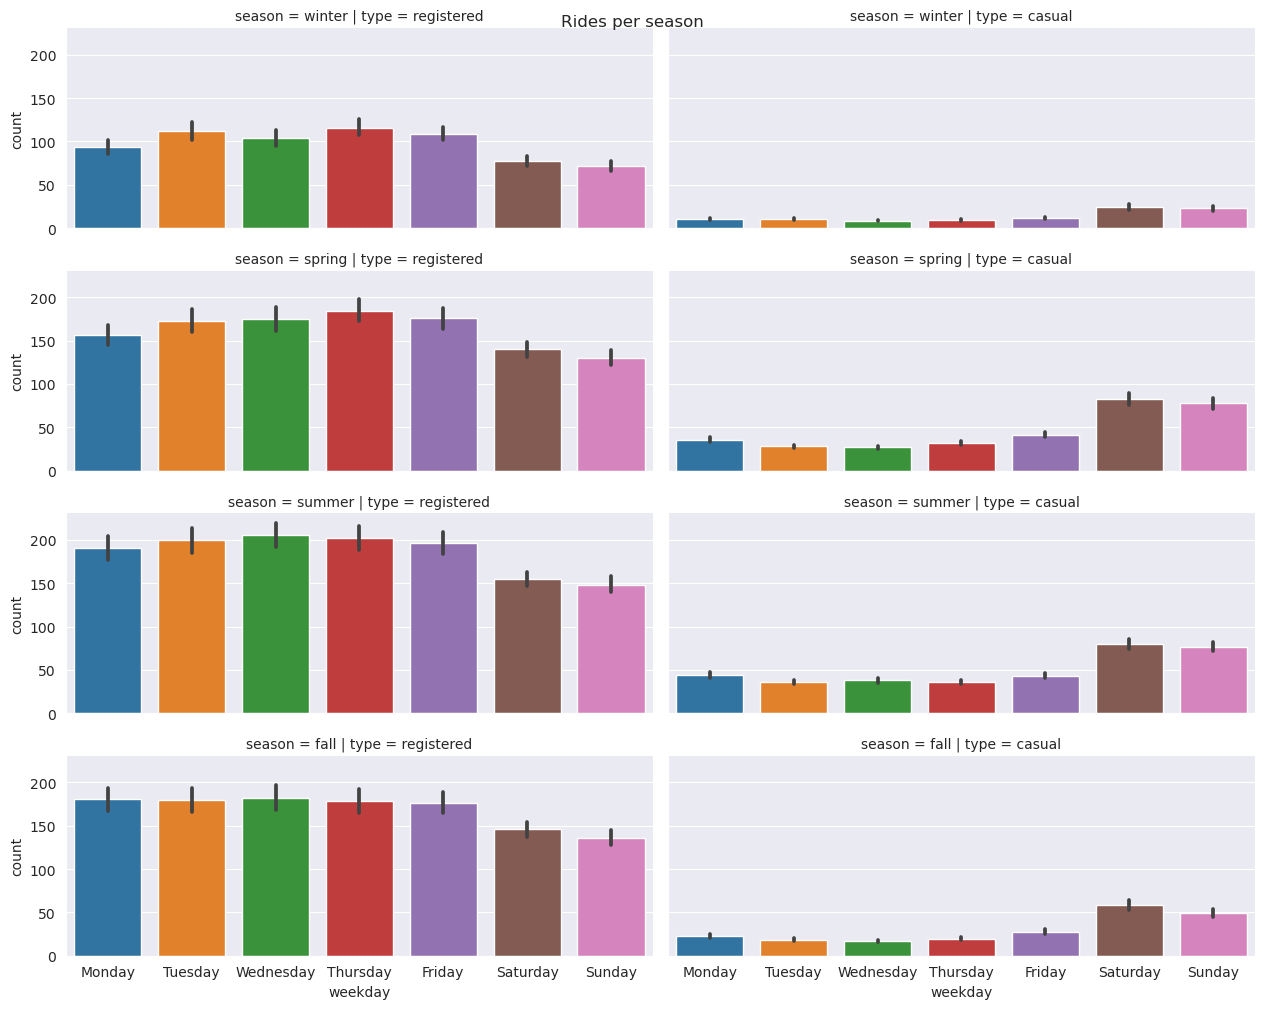

In [17]:
plot_data = preprocessed_data[['season','weekday','registered','casual']]
plot_data = plot_data.melt(id_vars=['season','weekday'], var_name='type', value_name='count')
sns.catplot(x='weekday', y='count',row='season', col='type',\
            kind='bar', data=plot_data, height=2.55, aspect=2.5,\
            order=['Monday', 'Tuesday','Wednesday','Thursday',\
                   'Friday','Saturday','Sunday'])
plt.suptitle('Rides per season')